<a href="https://colab.research.google.com/github/Charan-Teja-Kushuma/Charan-Teja-Kushuma/blob/main/AI_Powered_Image_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

# Make sure you have uploaded "MY_DATASET.zip"
zip_path = '/content/drive/MyDrive/Data Set Files/MY_DATASET.zip'
extract_path = '/content/'

# Clean up any old, broken folders first
!rm -rf /content/MY_DATASET

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset extracted to {extract_path}MY_DATASET")
except zipfile.BadZipFile:
    print(f"Error: '{zip_path}' is not a valid zip file or is corrupted.")
except FileNotFoundError:
    print(f"Error: '{zip_path}' not found. Please upload your zip file.")

Dataset extracted to /content/MY_DATASET


In [ ]:
import numpy as np
import cv2  # OpenCV for loading and resizing images
import os
import matplotlib.pyplot as plt

# --- 1. Define Dataset Parameters ---
DATASET_PATH = "/content/my_dataset"
IMG_SIZE = (128, 128) # We'll resize all images to this

# --- 2. Loop Through All Nested Folders and Load Images ---
images = []
labels = []
class_names_map = {} # Maps class names (e.g., 'jacket') to numbers (e.g., 0)
label_counter = 0

print("Loading images from custom dataset...")

for root, dirs, files in os.walk(DATASET_PATH):
    if not files:
        continue

    class_name = os.path.basename(root)

    if class_name not in class_names_map:
        class_names_map[class_name] = label_counter
        label_counter += 1

    current_label = class_names_map[class_name]

    for file_name in files:
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_path = os.path.join(root, file_name)

            try:
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMG_SIZE)

                images.append(img)
                labels.append(current_label)

            except Exception as e:
                print(f"Error loading {image_path}: {e}")

print("Loading complete.")

# --- 3. Create x_train and y_train ---
x_train = np.array(images)
y_train = np.array(labels)

# --- 4. Preprocess Data (Normalize) ---
# Also check if x_train is not empty to avoid errors
if x_train.size > 0:
    x_train = x_train.astype('float32') / 255.0

    # Create the final list of class names in the correct order
    class_names = [name for name, _ in sorted(class_names_map.items(), key=lambda item: item[1])]

    print(f"\n--- New Dataset Shapes ---")
    print(f"x_train shape: {x_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"Found {len(class_names)} classes: {class_names}")

    # --- 5. Create the Triplet "Lookup" Map ---
    def create_label_index_map(labels):
        label_to_indices = {label: np.where(labels == label)[0]
                             for label in np.unique(labels)}
        return label_to_indices

    train_label_map = create_label_index_map(y_train)
    print("\nTriplet lookup map created.")

    # --- 6. Create the Triplet Generator ---
    def get_triplet(images, label_map, labels):
        anchor_label = np.random.choice(list(label_map.keys()))
        anchor_index = np.random.choice(label_map[anchor_label])
        anchor_image = images[anchor_index]

        positive_index = np.random.choice(label_map[anchor_label])
        while positive_index == anchor_index:
            positive_index = np.random.choice(label_map[anchor_label])
        positive_image = images[positive_index]

        negative_label = np.random.choice(list(label_map.keys()))
        while negative_label == anchor_label:
            negative_label = np.random.choice(list(label_map.keys()))

        negative_index = np.random.choice(label_map[negative_label])
        negative_image = images[negative_index]

        return (anchor_image, positive_image, negative_image), (anchor_label, anchor_label, negative_label)

    print(f"\nCustom Dataset is ready! Your new INPUT_SHAPE is {x_train.shape[1:]}")
else:
    print("\nError: No images were loaded. 'x_train' is empty.")
    print("Please check your zip file and folder structure.")

Loading images from custom dataset...
Loading complete.

--- New Dataset Shapes ---
x_train shape: (1011, 128, 128, 3)
y_train shape: (1011,)
Found 12 classes: ['laptop', 'watch', 'phone', 'Landmarks', 'sneakers', 't_shirt', 'jacket', 'jeans', 'table', 'sofa', 'chair', 'lamp']

Triplet lookup map created.

Custom Dataset is ready! Your new INPUT_SHAPE is (128, 128, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import MobileNetV2

# --- 1. Define Model Parameters ---
# This line will now work correctly!
INPUT_SHAPE = x_train.shape[1:]
EMBEDDING_DIM = 128

# --- 2. Define the Base Network (using MobileNetV2) ---
def create_base_network(input_shape, embedding_dim=128):
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet')

    # Freeze the pre-trained layers
    base_model.trainable = False

    # Add our custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(embedding_dim, name="embedding_layer")(x)
    x = Lambda(lambda v: tf.math.l2_normalize(v, axis=1), name="l2_normalization")(x)

    base_network = Model(inputs=base_model.input, outputs=x, name="base_network")
    return base_network

# --- 3. Create the Triplet Network ---
base_network = create_base_network(INPUT_SHAPE, EMBEDDING_DIM)

anchor_input = Input(shape=INPUT_SHAPE, name="anchor_input")
positive_input = Input(shape=INPUT_SHAPE, name="positive_input")
negative_input = Input(shape=INPUT_SHAPE, name="negative_input")

anchor_embedding = base_network(anchor_input)
positive_embedding = base_network(positive_input)
negative_embedding = base_network(negative_input)

triplet_model = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=[anchor_embedding, positive_embedding, negative_embedding],
    name="triplet_model"
)

# --- 4. Display the Model Summaries ---
print("\n--- Base Network (MobileNetV2) Summary ---")
base_network.summary()

print(f"\nStep 3 Complete: Model upgraded to MobileNetV2 with embedding dim of {EMBEDDING_DIM}.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Base Network (MobileNetV2) Summary ---


Model: "base_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,618,816 (9.99 MB)

 Trainable params: 360,832 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Step 3 Complete: Model upgraded to MobileNetV2 with embedding dim of 128.



--- Starting Model Training ---
Epoch 1/10
Epoch 1 summary - Average Loss: 0.1845
Epoch 2/10
Epoch 2 summary - Average Loss: 0.0922
Epoch 3/10
Epoch 3 summary - Average Loss: 0.0606
Epoch 4/10
Epoch 4 summary - Average Loss: 0.0469
Epoch 5/10
Epoch 5 summary - Average Loss: 0.0385
Epoch 6/10
Epoch 6 summary - Average Loss: 0.0327
Epoch 7/10
Epoch 7 summary - Average Loss: 0.0371
Epoch 8/10
Epoch 8 summary - Average Loss: 0.0291
Epoch 9/10
Epoch 9 summary - Average Loss: 0.0283
Epoch 10/10
Epoch 10 summary - Average Loss: 0.0209
--- Training Complete ---


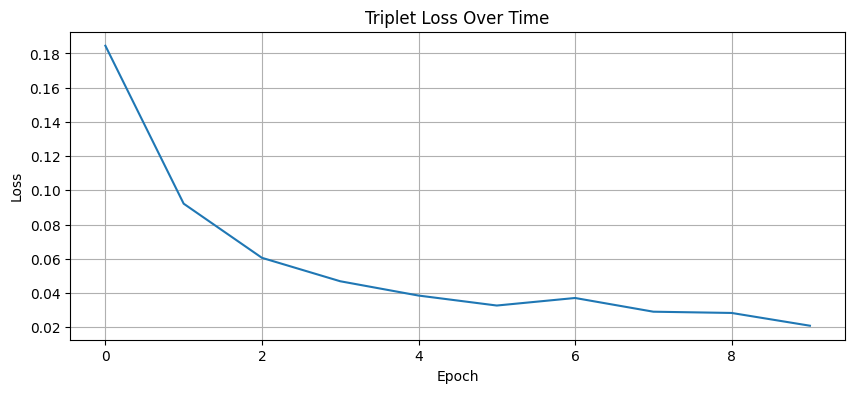


Step 4 Complete: Model has been trained.


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Define Constants and Loss Function ---
MARGIN = 0.5
BATCH_SIZE = 32 # Smaller batch size is safer for larger images
EPOCHS = 10
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE

def triplet_loss(anchor_emb, positive_emb, negative_emb, margin=MARGIN):
    pos_distance = tf.reduce_sum(tf.square(anchor_emb - positive_emb), axis=-1)
    neg_distance = tf.reduce_sum(tf.square(anchor_emb - negative_emb), axis=-1)
    loss = tf.maximum(pos_distance - neg_distance + margin, 0.0)
    return tf.reduce_mean(loss)

# --- 2. Create the tf.data Pipeline ---
def triplet_data_generator():
    while True:
        anchors = np.zeros((BATCH_SIZE, *INPUT_SHAPE))
        positives = np.zeros((BATCH_SIZE, *INPUT_SHAPE))
        negatives = np.zeros((BATCH_SIZE, *INPUT_SHAPE))

        for i in range(BATCH_SIZE):
            (anchors[i], positives[i], negatives[i]), _ = get_triplet(x_train, train_label_map, y_train)

        yield (anchors, positives, negatives), None

train_dataset = tf.data.Dataset.from_generator(
    triplet_data_generator,
    output_signature=(
        (tf.TensorSpec(shape=(None, *INPUT_SHAPE), dtype=tf.float32),
         tf.TensorSpec(shape=(None, *INPUT_SHAPE), dtype=tf.float32),
         tf.TensorSpec(shape=(None, *INPUT_SHAPE), dtype=tf.float32)),
        tf.TensorSpec(shape=None, dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

# --- 3. Define the Optimizer ---
optimizer = Adam(learning_rate=0.0001)

# --- 4. Define a Single Training Step ---
@tf.function
def train_step(inputs):
    anchor, positive, negative = inputs

    with tf.GradientTape() as tape:
        anchor_emb, positive_emb, negative_emb = triplet_model(
            [anchor, positive, negative], training=True
        )
        loss = triplet_loss(anchor_emb, positive_emb, negative_emb)

    gradients = tape.gradient(loss, triplet_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, triplet_model.trainable_variables))
    return loss

# --- 5. The Main Training Loop ---
print("\n--- Starting Model Training ---")

loss_history = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    epoch_loss = 0.0

    for step, (inputs, _) in enumerate(train_dataset.take(STEPS_PER_EPOCH)):
        loss_value = train_step(inputs)
        epoch_loss += loss_value

        if (step + 1) % 50 == 0: # Print every 50 steps
            print(f"  Step {step + 1}/{STEPS_PER_EPOCH} - Loss: {loss_value:.4f}")

    avg_loss = epoch_loss / STEPS_PER_EPOCH
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1} summary - Average Loss: {avg_loss:.4f}")

print("--- Training Complete ---")

# --- 6. Plot the Training Loss ---
plt.figure(figsize=(10, 4))
plt.plot([loss.numpy() for loss in loss_history])
plt.title('Triplet Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

print("\nStep 4 Complete: Model has been trained.")

--- Step 5: Visualizing the Results ---
Embedder model (base_network) extracted.
Generating embeddings for 1011 images...
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 797ms/step
Embeddings shape: (1011, 128)
Building nearest neighbors index...
Index built.

--- Running 5 Example Searches ---


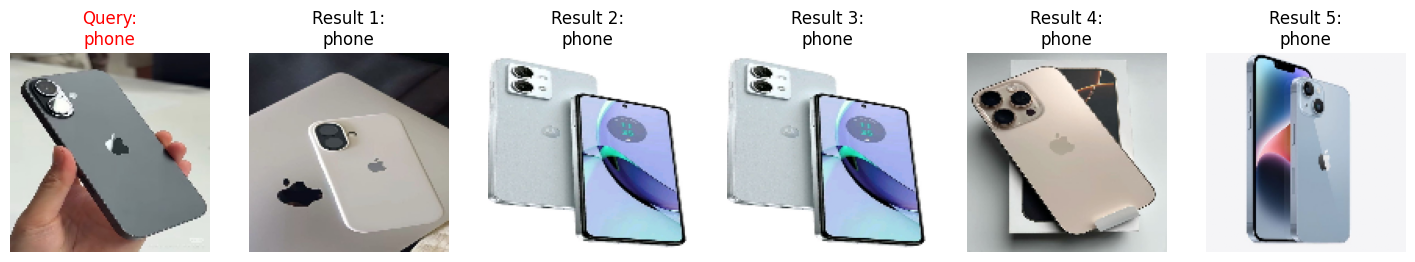

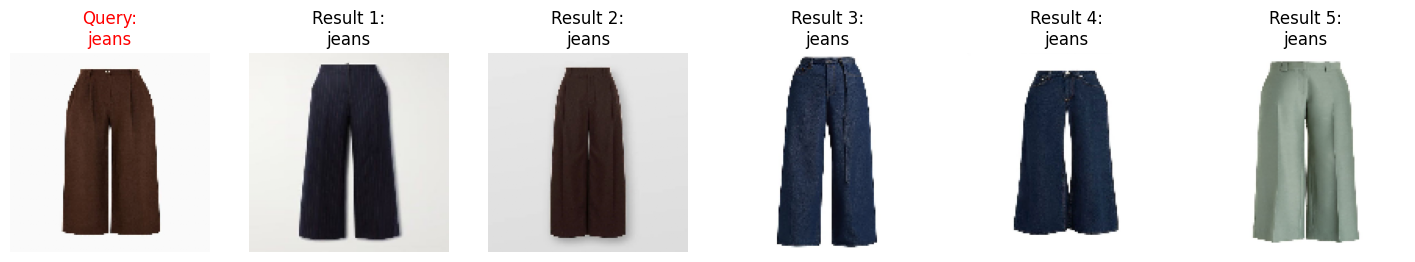

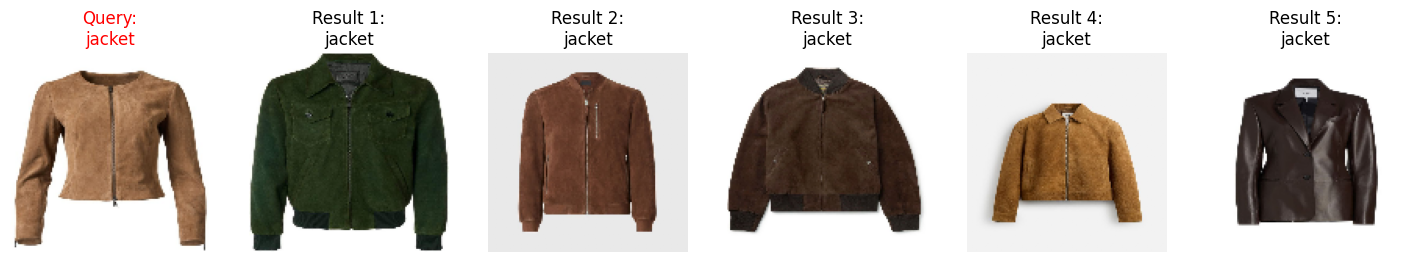

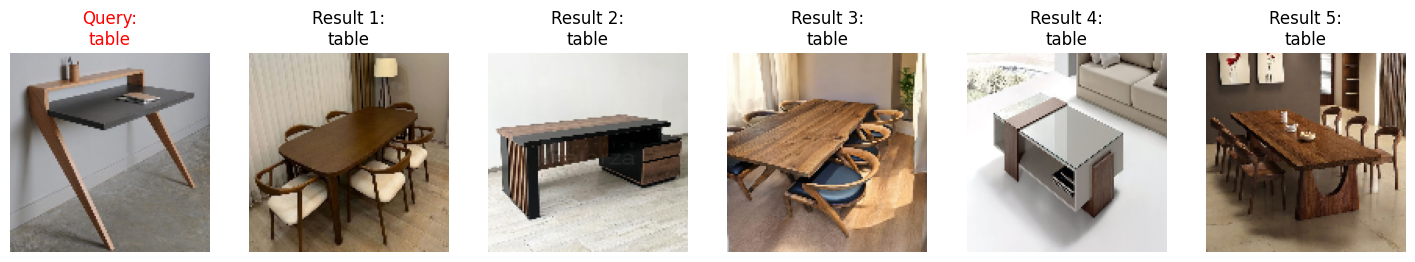

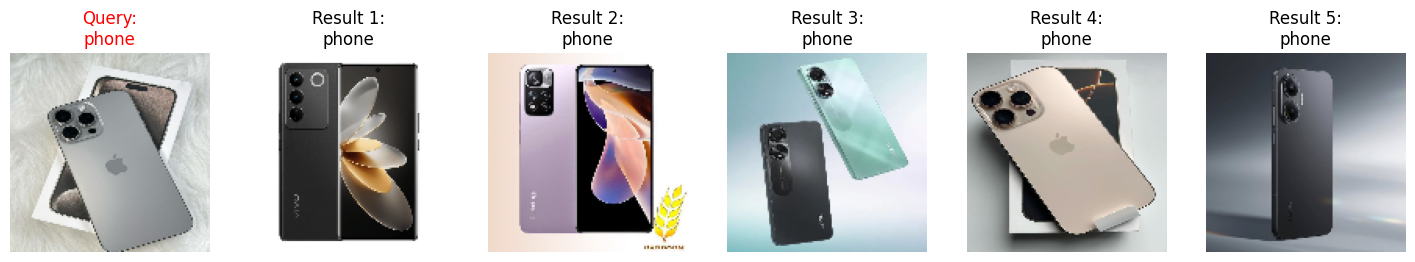


Project Complete: Search results visualized.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

print("--- Step 5: Visualizing the Results ---")

# --- 1. Get the trained Base Network ---
embedder_model = base_network
print("Embedder model (base_network) extracted.")

# --- 2. Generate Embeddings for all our images ---
# Note: We are using x_train as our search database
print(f"Generating embeddings for {len(x_train)} images...")
all_embeddings = embedder_model.predict(x_train, batch_size=64)
print(f"Embeddings shape: {all_embeddings.shape}")

# --- 3. Build a Search Index ---
print("Building nearest neighbors index...")
nn_index = NearestNeighbors(n_neighbors=6, metric='euclidean')
nn_index.fit(all_embeddings)
print("Index built.")

# --- 4. Test the Similarity Search ---

def find_similar_images(query_index, embeddings_dataset, nn_model, num_results=6):
    query_embedding = embeddings_dataset[query_index].reshape(1, -1)
    distances, indices = nn_model.kneighbors(query_embedding)
    return indices.squeeze()[:num_results]

def plot_search_results(query_index, result_indices, image_dataset, class_names_list):
    query_image = image_dataset[query_index]
    # Use y_train for labels now
    query_label = class_names_list[y_train[query_index]]

    num_results = len(result_indices)
    fig, axes = plt.subplots(1, num_results, figsize=(num_results * 3, 3))

    axes[0].imshow(query_image) # No .squeeze() needed for color images
    axes[0].set_title(f"Query:\n{query_label}", color='red', fontsize=12)
    axes[0].axis('off')

    for i in range(1, num_results):
        result_idx = result_indices[i]
        result_image = image_dataset[result_idx]
        result_label = class_names_list[y_train[result_idx]]

        axes[i].imshow(result_image)
        axes[i].set_title(f"Result {i}:\n{result_label}")
        axes[i].axis('off')

    plt.show()

# --- Pick 5 random images to test ---
print("\n--- Running 5 Example Searches ---")
for _ in range(5):
    query_idx = np.random.randint(0, len(x_train))
    similar_indices = find_similar_images(query_idx, all_embeddings, nn_index, num_results=6)

    # Use our custom 'class_names' list
    plot_search_results(query_idx, similar_indices, x_train, class_names)

print("\nProject Complete: Search results visualized.")